In [1]:
import torch
import sys
import os
import os.path as osp
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import ticker
import matplotlib as mpl
from matplotlib.colors import LogNorm
import matplotlib.patches as mpatches
from sklearn.metrics import precision_recall_curve, recall_score, precision_score, \
balanced_accuracy_score, accuracy_score
from sklearn import metrics
import math

In [2]:
os.environ['USER_PATH']='/home/users/richras/Ge2Net_Repo'
os.environ['USER_SCRATCH_PATH']="/scratch/users/richras"
os.environ['IN_PATH']='/scratch/groups/cdbustam/richras/data_in'
os.environ['OUT_PATH']='/scratch/groups/cdbustam/richras/data_out'
os.environ['LOG_PATH']='/scratch/groups/cdbustam/richras/logs/'

In [3]:
os.chdir(os.environ.get('USER_PATH'))

In [4]:
%load_ext autoreload
%autoreload 2
from src.utils.dataUtil import load_path, save_file, vcf2npy
from src.utils.modelUtil import Params, load_model, convert_coordinates
from src.utils.labelUtil import nearestNeighbourMapping, repeat_pop_arr
from src.utils.decorators import timer
from src.models.modelSelection import modelSelect
from src.models.modelParamsSelection import Selections
from src.models import Model_A, Model_B, Model_C, BOCD
from src.models.distributions import Multivariate_Gaussian
from src.main.evaluation import eval_cp_batch, reportChangePointMetrics, t_prMetrics, cpMethod, eval_cp_matrix, \
getCpPred, GcdLoss
from src.main.settings_model import parse_args
from src.models.Ge3Net import Ge3NetBase
from src.main.visualization import plot_changepoints
import inference

# load the model and use valid data 

In [288]:
# Specify the dataset to be evaluated
# chm22 pca full dataset and model
labels_path = osp.join(os.environ['OUT_PATH'],'humans/labels/data_id_1_geo')
data_path = osp.join(os.environ['OUT_PATH'],'humans/labels/data_id_1_geo')
models_path=osp.join(os.environ['OUT_PATH'],'humans/training/Model_H_exp_id_10_data_id_1_geo/') 
dataset_type='test'

In [289]:
config={}
config['data.labels']=labels_path 
config['data.dir']=data_path 
config['models.dir']=models_path
config['data.dataset_type']=dataset_type
config['cuda']='cuda'
config['model.loadBest']=True
json_path = osp.join(config['models.dir'], 'params.json')
assert osp.isfile(json_path), "No json configuration file found at {}".format(json_path)
params = Params(json_path)
params.rtnOuts=True
params.mc_dropout=False
params.mc_samples=100
params.cp_tol=1
params.test_gens=[0,2,4,8]
params.evalCp=True
params.evalBalancedGcd=True
params.evalExtraMainLosses=True
results, test_dataset, model, _=inference.main(config, params)

 device used: cuda
Loading the datasets...
Finished '_geoConvertLatLong2nVec' in 0.0722 secs
Finished 'mapping_func' in 0.3141 secs
Finished 'pop_mapping' in 0.1204 secs
Finished 'pop_mapping' in 0.1125 secs
Finished 'transform_data' in 33.6642 secs
Finished '__init__' in 95.5039 secs
Parameter count for model AuxNetwork:31752803
Parameter count for model PositionalEncoding:0
Parameter count for model attention_single:32342
Parameter count for model FFNN:32548
Parameter count for model BiRNN:35395
Parameter count for model logits_Block:2289
Total parameters:31855377
best val loss metrics : {'loss_main': 1022.7950114515362, 'loss_aux': 2302.5517583509786, 'l1_loss': 0.23750537297167365, 'mse': 0.054396821367344486, 'smooth_l1': 0.027125347057171255, 'weighted_loss': 0.23750537297167365}
at epoch : 119
train loss metrics: {'loss_main': 376.07291603652266, 'loss_aux': 1778.9024937115694, 'l1_loss': 0.08760086007491721, 'mse': 0.008409384318667413, 'smooth_l1': 0.004197009361169736, 'weigh

In [290]:
# def load_model(model_path, model_init, optimizer=None):
#     if not osp.exists(model_path):
#         # ToDo look into the raise exception error not
#         # coming from BaseException
#         print(f'{model_path} does not exist')
#         raise (f'{model_path} does not exist')
        
#     checkpoint = torch.load(model_path)

#     print(f"best val loss metrics : {checkpoint['val_accr']['t_accr']}")
#     print(f"at epoch : {checkpoint['epoch']}")
#     print(f"train loss metrics: {checkpoint['train_accr']['t_accr']}")

#     print(f"best val cp metrics : {checkpoint['val_accr']['t_cp_accr']}")
#     print(f"train cp metrics: {checkpoint['train_accr']['t_cp_accr']}")

#     print(f"best val sp metrics : {checkpoint['val_accr']['t_sp_accr']}")
#     print(f"train sp metrics: {checkpoint['train_accr']['t_sp_accr']}")

#     print(f"best val balanced gcd metrics : {checkpoint['val_accr']['t_balanced_gcd']}")
#     print(f"train balanced gcd metrics: {checkpoint['train_accr']['t_balanced_gcd']}")
    
#     print(f"checkpoint['model_state_dict']:{checkpoint['model_state_dict']}")
#     model_init.load_state_dict(checkpoint['model_state_dict'])
         
#     return model_init

In [291]:
# model_path = osp.join(config['models.dir'], 'models_dir')
# modelOption=modelSelect.get_selection()
# option = Selections.get_selection()
# criterion = option['loss'][params.criteria](reduction='sum', alpha=params.criteria_alpha, geography=params.geography)
# cp_criterion=option['cpMetrics']['loss_cp']
# model_init = modelOption['models'][params.model](params, criterion, cp_criterion)
# if config['model.loadBest']:
#     model = load_model(''.join([str(model_path),'/best.pt']), model_init)
# else:
#     model= load_model(''.join([str(model_path),'/last.pt']), model_init)


In [292]:
model.to(params.device)
next(model.parameters()).is_cuda

True

In [293]:
results.t_out.coord_main.shape

(1, 2964, 317, 3)

In [294]:
results.t_accr, results.t_cp_accr

({'l1_loss': 0.231020815231982,
  'loss_aux': 2183.461500146873,
  'loss_main': 989.6348101508321,
  'mse': 0.05191568562456031,
  'smooth_l1': 0.025889121649304337,
  'weighted_loss': 0.231020815231982},
 {'loss_cp': 0.31530401193586644,
  'prMetrics': OrderedDict([('Precision', array(0.41005449)),
               ('Recall', array(0.65564388)),
               ('Accuracy', array(0.97845013)),
               ('A_major', array(0.98394459)),
               ('BalancedAccuracy', 0.8197942341801079)])})

In [295]:
results.t_balanced_gcd

{'meanBalancedGcdGp': 1153.9429931640625,
 'meanBalancedGcdSp': 1081.30078125,
 'median': 676.7666625976562,
 'medianBalancedGcdGp': 1047.4132080078125,
 'medianBalancedGcdSp': 1079.3060302734375}

In [296]:
results_coord_main=results.t_out.coord_main.mean(0)

In [297]:
y_pred = results_coord_main
n_vec_dim=y_pred.shape[-1]
data_tensor = torch.tensor(y_pred).float()
batch_size_cpd = data_tensor.shape[0]
mu_prior = torch.zeros((batch_size_cpd, 1,n_vec_dim))
mean_var=torch.mean(torch.var(data_tensor, dim =1),dim=0).unsqueeze(0)
cov_prior = (mean_var.repeat(batch_size_cpd,1).unsqueeze(1)* torch.eye(n_vec_dim)).reshape(batch_size_cpd,1,n_vec_dim,n_vec_dim)
cov_x = cov_prior
likelihood_model = Multivariate_Gaussian(mu_prior, cov_prior, cov_x)
T = params.n_win
model_cpd = BOCD.BOCD(None, T, likelihood_model, batch_size_cpd)
_,_,_,_=model_cpd.run_recursive(data_tensor, 'cpu')

Finished 'run_recursive' in 184.9210 secs


In [298]:
granular_pop_dict = load_path(osp.join(labels_path, 'granular_pop.pkl'), en_pickle=True)
superop_dict=load_path(osp.join(labels_path, 'superpop.pkl'), en_pickle=True)
pop_sample_map=pd.read_csv(osp.join(labels_path, 'pop_sample_map.tsv'),sep="\t")
pop_arr=repeat_pop_arr(pop_sample_map)
cp_target=test_dataset.data['cps']
seqlen=cp_target.shape[1]
rev_pop_dict={v:k for k,v in granular_pop_dict.items()}

In [299]:
cp_target.shape

(2964, 317)

In [806]:
# index = 2500
# index=2620
# index=2650
# index=3000
# index=3100
# index=2300
# index=2320
# index=2338 #interesting Mansi pop
# index=2339 # nice example showing Karitiana
# index=2344 #interesting clusters of Mongolia
# index=2346 # interesting African diversity
# index=2355#int. Iranian sample
# index=2366# Piapioco and Pima both
# index=2388#int example
# index=2398#Biaka/Luhya
# index=2403#Quechua
# index=2414#incorrect Khomani San
# index=2421#uyugur
# index=2465#balochi similar to MAkrani slave trade
# index=2482# interesting Indo euro
# index=2876 #icelandic example
# index=3533 #San and icelandic
# index=1007 #Surui
# index=2974 #Surui nice example
#1873# nice diversity of samples
index=np.random.choice(idxOfInterest)
# index=830
# index=511
# index=1040 #San
# index=2205#1007 #2205, for 3_geo
# index=437
print(index)
true_cpsSample=cp_target[index,:]
y_predSample=results_coord_main[index,:]
y_trueSample=test_dataset.data['y'][index,:]
granularpopSample=test_dataset.data['granular_pop'][index,:]
namesSample=[rev_pop_dict[i] for i in granularpopSample.astype(int)]

2432


In [807]:
y_predSample.shape

(317, 3)

In [808]:
pred_cps=getCpPred(cpMethod.gradient.name, y_predSample, 0.1, 1, len(true_cpsSample))
pred_cps=pred_cps.squeeze(0).detach().cpu().numpy()# squeeze the batch dimension of 1

In [809]:
predBOCDSample=model_cpd.cp[index,:]
pred_cps_BOCD=getCpPred(cpMethod.BOCD.name, predBOCDSample, 5.0, 1, len(true_cpsSample))
pred_cps_BOCD=pred_cps_BOCD.squeeze(0).detach().cpu().numpy()# squeeze the batch dimension of 1

In [810]:
cpIdx=np.nonzero(pred_cps_BOCD)[0]
remWin=3
for i in cpIdx:
    low=max(0,i-remWin)
    high=min(seqlen, i+remWin)
    pred_cps_BOCD[low:high]=1

In [811]:
mappedSpArr=nearestNeighbourMapping(labels_path, y_predSample.reshape(-1,3))
# mappedSpArr=mappedSpArr.squeeze(1)

Finished 'nearestNeighbourMapping' in 0.0895 secs


In [812]:
y_predsTrue=test_dataset.data['y'].reshape(-1,3)
superpopsTrue=test_dataset.data['superpop'].reshape(-1,)

In [813]:
@timer
def plot_sample(granularPopSample, y_predSample, y_trueSample, **kwargs):
    backgroundAxis=kwargs.get('backgroundAxis')
    y_predCps=kwargs.get('y_predCps')
    y_preds=kwargs.get('y_preds')
    superpops=kwargs.get('superpops')
    cpShow=kwargs.get('cpShow')
    pred_cps=kwargs.get('pred_cps')
    mappedSpArr=kwargs.get('mappedSpArr')
    fig, ax = plt.subplots(figsize=(12,14))
    
    gs1 = fig.add_gridspec(nrows=3, ncols=1, height_ratios=[13,1,1])
    ax1=fig.add_subplot(gs1[0],projection='3d')
    ax2=fig.add_subplot(gs1[1])
    ax3=fig.add_subplot(gs1[2])
    for axis in [ax, ax2, ax3]:
        axis.set_yticks([])
        axis.spines['top'].set_color('none')
        axis.spines['left'].set_color('none')
        axis.spines['right'].set_color('none')
    ax.set_xticks([])
    plt.subplots_adjust(hspace=0.01)
    
    if backgroundAxis is not None:
        lgnd, colorsPop_sp_dict =plot_all(ax1, y_preds, superpops, cpShow=False)
    else:
        continentaPops=list(superop_dict.values())
        colors_Sp = sns.color_palette("bright", 10)
        del colors_Sp[1]
        del colors_Sp[4]
        del colors_Sp[5]
        colorsPop_sp_dict = {k:v for k,v in zip(continentaPops, colors_Sp)}
        colorsPop_sp_dict[-1]=(0.7,0.7,0.7) # grey color
        patches=[]
        for k, val in superop_dict.items():
            patches.append(mpatches.Patch(color = colorsPop_sp_dict[val], label = k))
        lgnd = ax1.legend(handles=patches, loc="upper right",fontsize=15)
    ax1.add_artist(lgnd)    
    colors_pop = sns.color_palette("rainbow", len(np.unique(granularPopSample)))
    colors_pop_dict = {k:v for k,v in zip(np.unique(granularPopSample), colors_pop)}

    alpha=[1]*len(y_predSample)
    if cpShow is None:
#         alpha=(pred_cps==0).astype(float)
        unknownIdx=np.nonzero(pred_cps)[0]
        print(f"number of changepoints removed:{len(unknownIdx)},{len(unknownIdx)/len(y_predSample)}")
        granularPopNames=["UNK" if i in unknownIdx else granularPopSample[i] for i in range(len(granularPopSample))]
        colors_pop_dict["UNK"]=(0.9,0.9,0.9) # grey color
        mappedSpArr[unknownIdx]=-1
    
    ax1.scatter(y_predSample[:,0], y_predSample[:,1], y_predSample[:,2], \
               color = [colors_pop_dict[x]+(y,) for x,y in zip(granularPopNames, alpha)], s=50, zorder=0) 
    ax1.scatter(y_trueSample[:,0], y_trueSample[:,1], y_trueSample[:,2], \
               color = [colors_pop_dict[x] for x in granularPopSample], marker='X', s=200, zorder=0)
    
    for axis in [ax1.xaxis, ax1.yaxis, ax1.zaxis]:
        axis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        axis._axinfo["grid"]['color'] = (1,1,1,0)
    patches=[]
    for i, val in enumerate(np.unique(granularPopSample)):
        patches.append(mpatches.Patch(color = colors_pop_dict[val], label = val))
    patches.append(mpatches.Patch(color = (0.9,0.9,0.9), label = "UNK"))
    ax1.legend(handles=patches, loc="upper left", fontsize=20)
    
    #chm plot ground truth
    ax2.scatter(np.arange(len(y_trueSample)),np.ones(len(y_trueSample)),\
                color=[colors_pop_dict[x] for x in granularPopSample], marker='s')
    ax2.set_title('Labeled Chromosome22', fontsize=30, y=0.3)
    #chm plot of predictions
    ax3.scatter(np.arange(len(mappedSpArr)),np.ones(len(mappedSpArr)),\
                color=[colorsPop_sp_dict[x]+(y,) for x,y in zip(mappedSpArr,alpha)], marker='s')
    ax3.set_title('Predicted Chromosome22', fontsize=30, y=0.3)
    
    for ax in [ax2, ax3]:
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1.0))
        ax.xaxis.set_minor_locator(ticker.MultipleLocator(4))
        ax.xaxis.set_ticks_position('bottom')
        ax.tick_params(which='major', width=2, length=10, labelsize=25)
        ax.tick_params(which='minor', width=2, length=10, labelsize=10)
        ax.set_xlim(0, 316)
        ax.set_ylim(0.99,1.09)
        positions = [0, 160, 300]
        x_labels = [0, 150000, 317000]
        ax.xaxis.set_major_locator(ticker.FixedLocator(positions))
        ax.xaxis.set_major_formatter(ticker.FixedFormatter(x_labels))
    
    fig.tight_layout()
    plt.show()
    plt.close('all')

number of changepoints removed:18,0.056782334384858045


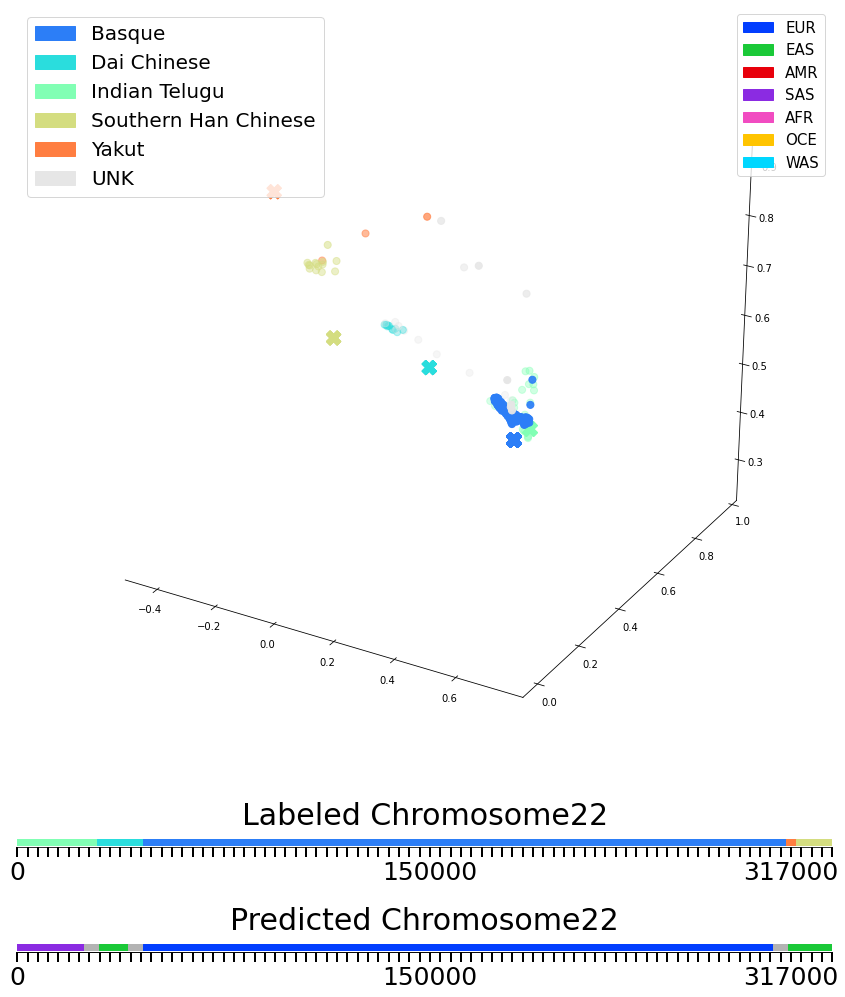

Finished 'plot_sample' in 1.0048 secs


In [814]:
plot_sample(namesSample, y_predSample, y_trueSample, pred_cps=pred_cps_BOCD, mappedSpArr=mappedSpArr)

In [815]:
def plot_coordinates_map(granularPopNames, pred_coord, lbl_coord, **kwargs):
    """
    plotly plot for coordinates on a map
    label: target label vector (int) for the specific sample
    data_coordinates: lat, long for the specific sample
    rev_pop_order: dict with keys as target label ints and values
    as granular population name
    """
    cpShow=kwargs.get('cpShow')
    pred_cps=kwargs.get('pred_cps') 
    alpha=[1.0]*len(lbl_coord)
    if cpShow:
        unknownIdx=np.nonzero(pred_cps)[0]
        granularPopNames=["UNK" if i in unknownIdx else granularPopNames[i] for i in range(len(granularPopNames))]
    fig = go.Figure(go.Scattergeo())
    colors_pop = sns.color_palette("rainbow", len(np.unique(granularPopNames)))
    
    colors_pop_dict = {k:v for k,v in zip(np.unique(granularPopNames), colors_pop)}
    colors_pop_dict['UNK']=(188,188,188) # grey color
    fig.add_trace(go.Scattergeo(lon=pred_coord[:,1], lat=pred_coord[:,0], text = granularPopNames,\
    marker_color=['rgba'+str(colors_pop_dict[x]+(y,)) for x,y in zip(granularPopNames, alpha)]))
    fig.update_traces(marker_size = 5)
    fig.add_trace(go.Scattergeo(lon=lbl_coord[:,1], lat=lbl_coord[:,0], marker = dict(symbol = 'square'), \
                                text = granularPopNames))
    fig.update_traces(marker_size = 5)

    fig.show()
    plt.show()
    plt.close('all')

In [816]:
y_trueSample.shape

(317, 3)

In [817]:
lbl_coord=convert_coordinates(y_trueSample[:,0], y_trueSample[:,1], y_trueSample[:,2])
pred_coord=convert_coordinates(y_predSample[:,0], y_predSample[:,1], y_predSample[:,2])
granularPopNames=namesSample
plot_coordinates_map(granularPopNames, pred_coord, lbl_coord, pred_cps=pred_cps_BOCD, cpShow=True)

In [684]:
def rawGcd(self, input_y, target):
    if torch.is_tensor(input_y):
        return torch.acos(torch.sum(input_y * target, dim=-1).clamp(-1.0 + self.eps, 1.0 - self.eps)) * self.earth_radius
    elif isinstance(input_y, np.ndarray):
        return np.arccos(np.clip(np.sum(input_y * target, axis=-1), a_min=-1.0 + self.eps, a_max=1.0 - self.eps)) * self.earth_radius

In [685]:
def gcd_loss(y_pred, y, mask=None):
    if mask is not None: 
        print(mask.shape)
        mask=mask.astype(int)
    if mask is None:
        mask = 1
    eps = 1e-4
    temp = np.arccos(np.clip(np.sum(y_pred * y, axis=-1),a_min=-1.0 + eps, a_max=1.0 - eps)).reshape(-1,1)
    sum_gcd = np.sum(temp * 6371 * mask)
    return sum_gcd

In [34]:
loss_main={}

loss_main['no_mask']=gcd_loss(y_predSample, y_trueSample)/317.0
trueCpMask=(true_cpsSample==0)[...,np.newaxis]
PredCpMask=(pred_cps_BOCD==0)[...,np.newaxis]
# PredCpMask=np.repeat(PredCpMask,3,1)
print(PredCpMask.shape)
# loss_main['trueCpMask']=gcd_loss(y_predSample, y_trueSample, mask=trueCpMask)/trueCpMask.sum()
loss_main['PredCpMask']=gcd_loss(y_predSample, y_trueSample, mask=PredCpMask)/(317.0-12.0)
loss_main

(317, 1)
(317, 1)


{'PredCpMask': 996.5155942763969, 'no_mask': 1268.8211746035172}

In [35]:
np.sum(PredCpMask)

290

In [ ]:
115498040.10265198/305

In [ ]:
PredCpMask

In [ ]:
PredCpMask.sum()

In [ ]:
gcd_loss(y_predSample, y_trueSample, mask=PredCpMask)

In [ ]:
y_predSample*PredCpMask

In [ ]:
trueCpMask.sum()-PredCpMask.sum()

In [ ]:
unknownIdx=np.nonzero(pred_cps_BOCD)[0]
gcdUnknownIdx=GcdLoss()(y_predSample[unknownIdx,:], y_trueSample[unknownIdx,:])/12.0
gcdUnknownIdx

In [ ]:
unknownIdx

In [ ]:
knownIdx=np.delete(np.arange(317), unknownIdx)
knownIdx

In [ ]:
gcdUnknownIdxSum=GcdLoss()(y_predSample[unknownIdx,:], y_trueSample[unknownIdx,:])
AllIdxSum = GcdLoss()(y_predSample, y_trueSample)
knownIdxSum = GcdLoss()(y_predSample[knownIdx,:], y_trueSample[knownIdx,:])
print(AllIdxSum, knownIdxSum, gcdUnknownIdxSum)
print(AllIdxSum/317.0, knownIdxSum/(317.0-12.0), gcdUnknownIdxSum/12.0)

In [ ]:
def plot_changepoints(true_cps, pred_cps, y_pred, bocp_rl, y_var, popNames):
    fig, ax = plt.subplots(4,1,figsize=[18,20])
    T=len(true_cps)
    ax[0].plot(y_pred)
    ax[0].text(0, np.max(y_pred)-0.5, s=popNames[0], size=15)
    for i in np.nonzero(true_cps)[0]:
        ax[0].plot([i,i], [np.min(y_pred), np.max(y_pred)], 'r' )
        ax[0].text(i, np.max(y_pred)-0.5, s=popNames[i+1], size=15)
    
    ax[1].plot(np.arange(T+1), bocp_rl)
    ax[2].plot(pred_cps)
    ax[3].plot(true_cps)
    
    ax[0].set_title("n_vectors")
    ax[1].set_title("BOCD (post process) run_length")
    ax[2].set_title("BOCD (post process) cp")
    ax[3].set_title("True Cps")
    plt.show()

In [ ]:
y_var=y_predSample[:,1:]-y_predSample[:,:-1]
bocp_rlSample=model_cpd.cp.detach().cpu().numpy()[index,:]
plot_changepoints(true_cpsSample, pred_cps_BOCD, y_predSample, bocp_rlSample, y_var, namesSample)

In [ ]:
y_predSample.shape

In [ ]:
lbl_coord=convert_coordinates(y_trueSample[:,0], y_trueSample[:,1], y_trueSample[:,2])
pred_coord=convert_coordinates(y_predSample[:,0], y_predSample[:,1], y_predSample[:,2])
granularPopNames=namesSample
plot_coordinates_map(granularPopNames, pred_coord, lbl_coord, pred_cps=pred_cps_BOCD, cpShow=True)

In [ ]:
lbl_coord=convert_coordinates(y_trueSample[:,0], y_trueSample[:,1], y_trueSample[:,2])
pred_coord=convert_coordinates(y_predSample[:,0], y_predSample[:,1], y_predSample[:,2])
granularPopNames=namesSample
plot_coordinates_map(granularPopNames, pred_coord, lbl_coord, pred_cps=pred_cps_BOCD, cpShow=True)

In [670]:
idxOfInterest=np.unique(np.nonzero(test_dataset.data['granular_pop']==granular_pop_dict["Basque"])[0])

In [671]:
idxOfInterest

array([ 554,  555,  556,  557,  614,  627,  733,  826,  830,  853,  950,
       1053, 1243, 1360, 1379, 1511, 1572, 1575, 1581, 1592, 1605, 1669,
       1755, 1796, 1819, 1822, 1826, 1860, 1907, 1951, 1996, 2006, 2059,
       2099, 2160, 2190, 2262, 2274, 2276, 2281, 2296, 2323, 2326, 2329,
       2330, 2338, 2432, 2435, 2446, 2454, 2461, 2493, 2494, 2495, 2506,
       2522, 2524, 2533, 2542, 2548, 2577, 2623, 2631, 2633, 2645, 2669,
       2688, 2721, 2784, 2805, 2813, 2823, 2824, 2826, 2828, 2861, 2893,
       2897, 2905, 2941])

In [ ]:
@timer
def plot_all(ax, y_preds, superpops, **kwargs):
    cpShow=kwargs.get('cpShow')
    pred_cps=kwargs.get('pred_cps')    
    continentaPops=list(superop_dict.values())
    colors_pop = sns.color_palette("bright", 10)
    del colors_pop[1]
    del colors_pop[4]
    del colors_pop[5]
    colors_pop_dict = {k:v for k,v in zip(continentaPops, colors_pop)}
    
    alpha=[0.03]*len(y_preds)
    if cpShow is None:
        alpha=(pred_cps==0).astype(float)
    
    ax.scatter(y_preds[:,0], y_preds[:,1], y_preds[:,2], \
               color = [colors_pop_dict[x]+(y,) for x,y in zip(superpops, alpha)], marker=".", s=0.05,zorder=-1) 
    
    patches=[]
    for k, val in superop_dict.items():
        patches.append(mpatches.Patch(color = colors_pop_dict[val], label = k))
    lgnd = ax.legend(handles=patches, loc="upper right", fontsize=15)
    return lgnd, colors_pop_dict


In [ ]:
y_preds=results.t_out.coord_main
y_predCps=getCpPred(cpMethod.gradient.name, y_predSample, 0.1, y_preds.shape[0], y_preds.shape[1])
y_predCps=y_predCps.reshape(-1,)
y_preds=y_preds.reshape(-1,3)
superpops=test_dataset.data['superpop'].reshape(-1,)

In [376]:
granular_pop_dict

{'Abkhasian': 114,
 'Adygei': 70,
 'Albanian': 115,
 'Altaian': 87,
 'Ami': 97,
 'Armenian': 116,
 'Atayal': 98,
 'Australian': 74,
 'Balochi': 22,
 'BantuHerero': 76,
 'BantuKenya': 71,
 'BantuSouthAfrica': 49,
 'BantuTswana': 77,
 'Basque': 69,
 'Bedouin': 36,
 'Bengali': 10,
 'Bergamo_Italian': 53,
 'Biaka': 30,
 'Bougainville': 31,
 'Brahmin': 105,
 'Brahui': 21,
 'British': 0,
 'Bulgarian': 117,
 'Burmese': 99,
 'Burusho': 28,
 'Cambodian': 40,
 'Chane': 83,
 'Chechen': 118,
 'Colombian': 39,
 'Crete': 75,
 'Czech': 119,
 'Dai': 64,
 'Dai Chinese': 3,
 'Daur': 57,
 'Dinka': 72,
 'Druze': 35,
 'Dusun': 103,
 'Esan': 9,
 'Eskimo_Chaplin': 88,
 'Eskimo_Naukan': 89,
 'Eskimo_Sireniki': 90,
 'Estonian': 120,
 'Even': 91,
 'Finnish': 1,
 'French': 32,
 'Gambian Mandinka': 8,
 'Georgian_Mingrelian': 121,
 'Greek': 122,
 'Gujarati': 20,
 'Han': 41,
 'Han Chinese': 15,
 'Hazara': 23,
 'Hezhen': 59,
 'Hungarian': 123,
 'Icelandic': 124,
 'Igorot': 104,
 'Indian Telugu': 13,
 'Iranian': 125,